# Vanilla VQ-VAE applied on MNIST

## Dependencies

In [1]:
!nvidia-smi

Mon Nov 28 15:01:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:61:00.0 Off |                    0 |
| N/A   31C    P0    58W / 300W |   1086MiB / 32510MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  Off  | 00000000:62:00.0 Off |                    0 |
| N/A   

In [2]:
import os, sys
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
PROJECT_ROOT = "/project/fdreyer/projects/vqvae-vc"
sys.path.append(PROJECT_ROOT)
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.optim import Adam
from src.models.encoders import ResNetEncoder
from src.models.quantizers import VanillaVectorQuantizer
from src.models.decoders import ResNetDecoder
from src.models.vqvae import VQVAE
from src.losses.vqvae_losses import VQVAELoss
from src.training.vqvae_trainers import VQVAETrainer
from src.training.codebook_collapse_handlers import RandomRestarts
from src.evaluation.visualizations import plot_original_reconstruction_matrix
from src.evaluation.sanity_checks import embedding_vector_usage_freq
from matplotlib import pyplot as plt

device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


## Load MNIST Dataset

Overwrite \_\_getitem\_\_() of datasets.MNIST class to ignore class labels:

In [3]:
class MNIST_wo_labels(datasets.MNIST):

    def __getitem__(self, idx):
        sample = super().__getitem__(idx)
        return sample[0]

In [4]:
train_dataset = MNIST_wo_labels(root="data", train=True, download=True, transform=ToTensor())
test_dataset = MNIST_wo_labels(root="data", train=False, download=True, transform=ToTensor())

In [5]:
print(train_dataset[0].shape)

torch.Size([1, 28, 28])


In [6]:
print(f"Train data: \n{train_dataset}")
print(f"\nTest data: \n{test_dataset}")

Train data: 
Dataset MNIST_wo_labels
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

Test data: 
Dataset MNIST_wo_labels
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


## Configure DataLoader

In [7]:
BATCH_SIZE = 64

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [8]:
X = next(iter(train_dataloader))
X.shape

torch.Size([64, 1, 28, 28])

## Instatiate VQ-VAE

In [9]:
encoder = ResNetEncoder(1, 32)
quantizer = VanillaVectorQuantizer(32, 100)
decoder = ResNetDecoder(32, 1)
vqvae = VQVAE(encoder, quantizer, decoder)

## Train VQ-VAE on MNIST

In [10]:
loss_fn = VQVAELoss(beta=0.25)
optimizer = Adam(vqvae.parameters())
codebook_collapse_handler = RandomRestarts(vqvae.quantizer.codebook, usage_threshold=0.01, alpha=0.1, device=device)
trainer = VQVAETrainer(vqvae, train_dataloader, test_dataloader, loss_fn, optimizer, codebook_collapse_handler=codebook_collapse_handler, device=device)

In [11]:
trainer.train(5)

Epoch 1
-------------------
below threshold: 43
Train Loss: 0.375027 [    0 / 60000]
below threshold: 16
below threshold: 20
below threshold: 37
below threshold: 14
below threshold: 8
below threshold: 7
below threshold: 4
below threshold: 6
below threshold: 5
below threshold: 6
below threshold: 9
below threshold: 3
below threshold: 1
below threshold: 2
below threshold: 1
below threshold: 1
below threshold: 1
below threshold: 2
below threshold: 2
below threshold: 1
below threshold: 2
below threshold: 3
below threshold: 1
below threshold: 1
below threshold: 1
below threshold: 2
below threshold: 3
below threshold: 1
below threshold: 1
below threshold: 2
below threshold: 1
below threshold: 1
below threshold: 3
below threshold: 1
below threshold: 1
below threshold: 1
below threshold: 1
below threshold: 1
below threshold: 1
below threshold: 1
below threshold: 2
below threshold: 1
below threshold: 2
below threshold: 1
below threshold: 1
below threshold: 2
below threshold: 1
below threshold: 1

Plotting Reconstructions:

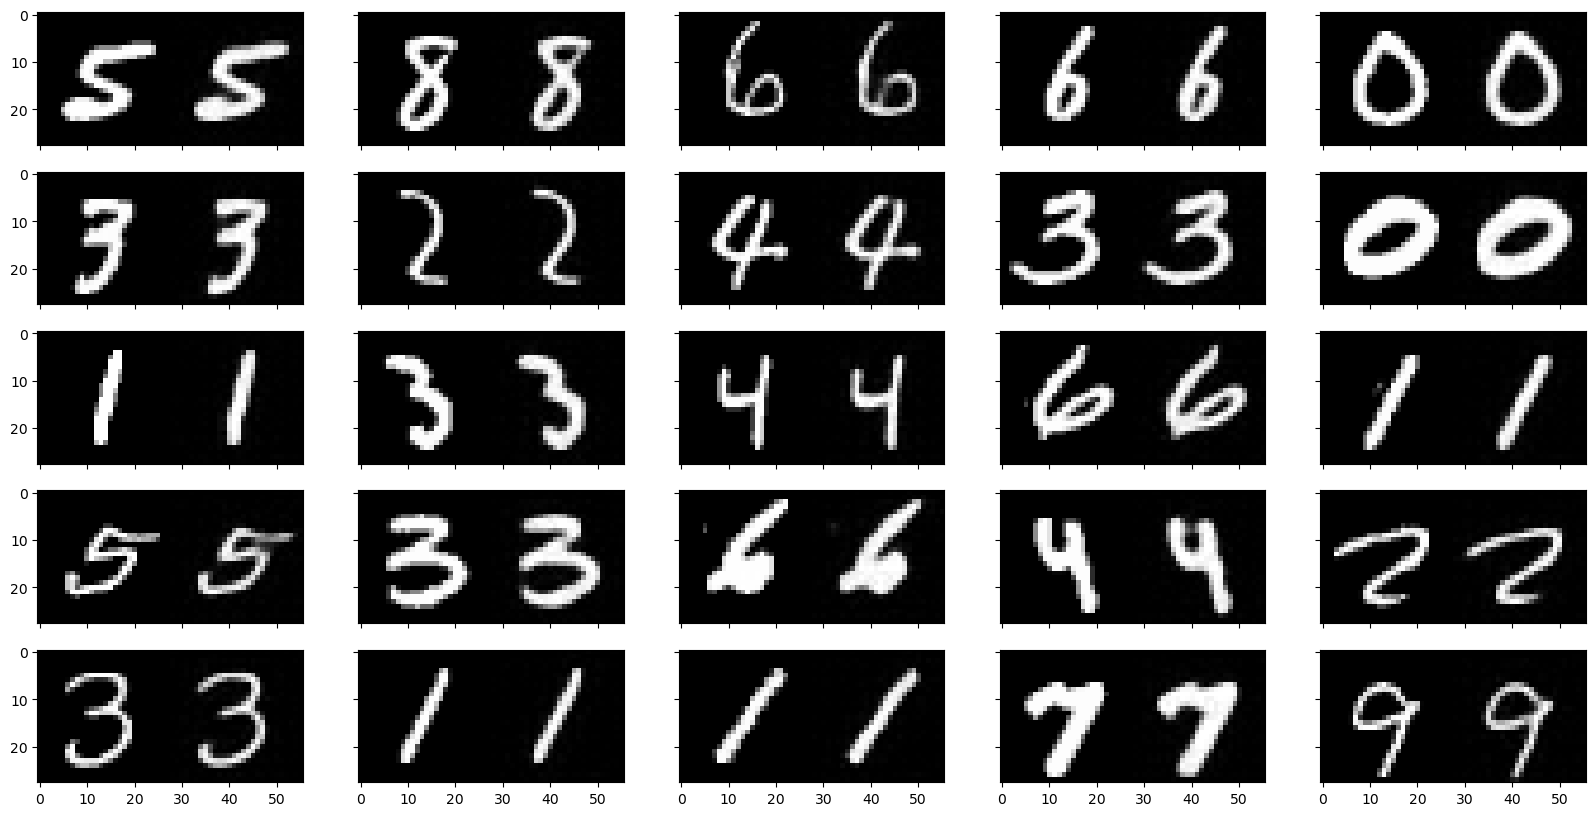

In [12]:
fig, axes = plot_original_reconstruction_matrix(5, 5, vqvae, test_dataset, device=device)
plt.show()

Check for codebook collapse (Each entry here represents one embedding vector and displays the number of times it was selected by the vector quantizer):

In [13]:
embedding_vector_usage_freq(vqvae, train_dataloader, device=device)

tensor([ 20042,  18728,  15862,  12037,  36792,  19007,  15158,  86022,  12546,
         30811,  17086,  26110,  20620,  15190,  78525,  11931,  15441,  10902,
         30948,  13291,  27564,  12190,  17303,  26447,  23588,  21553,  55456,
         13805,  21029,  26364,  16015,  37286,  28736,  23738,  76245,  58931,
         21682,  14920,  10608,  16566,  28018,  27269,  37920,  13533,  74483,
         19324,  20367,  46865,  15018,  73077,  13440,  85104,  31338,  14510,
         26584,  14524,  16955,  29368,  28579, 249753,  11297,  15664,  16618,
         12080,  27665,  23946,  31081,  28415,  33997,  31314,  26870,  26579,
         13312,  27026,  27448,  13657,  26447,  24320,  11274,  17142,  14577,
         13503,  67147,  24301,  15669,  15679,  20909,  13363,  33667,  26083,
         75226,  14486,  14693,  29934,  26021,  20863,  14535,  20050,  18899,
         91139], device='cuda:0')

In [14]:
embedding_vector_usage_freq(vqvae, test_dataloader, device=device)

tensor([ 3282,  3215,  2752,  1925,  6362,  3254,  2602, 14585,  2097,  5311,
         2875,  4323,  3593,  2460, 13274,  2022,  2718,  1827,  5238,  2153,
         4474,  1965,  2837,  4320,  3960,  3427,  9058,  2279,  3722,  4331,
         2465,  6370,  4765,  3914, 12761,  9878,  3667,  2474,  1668,  2844,
         4630,  4521,  6681,  2324, 12371,  3149,  3491,  8102,  2697, 12239,
         2181, 14435,  5191,  2316,  4385,  2379,  2784,  4294,  4803, 40982,
         1850,  2767,  2925,  1974,  4590,  4095,  5219,  4638,  5719,  5286,
         4420,  4151,  2137,  4454,  4652,  2208,  4469,  3906,  1820,  2754,
         2404,  2304, 11264,  4004,  2629,  2806,  3285,  2181,  5836,  4383,
        12468,  2462,  2463,  5140,  4278,  3466,  2447,  3347,  2823, 14974],
       device='cuda:0')